In [1]:
from time import time
import matplotlib
#this will prevent the figure from popping up
matplotlib.use('Agg')

from matplotlib import pyplot as plt
import numpy as np


def simple_mandelbrot(width, height, real_low, real_high, imag_low, imag_high, max_iters, upper_bound):
    
    real_vals = np.linspace(real_low, real_high, width)
    imag_vals = np.linspace(imag_low, imag_high, height)
        
    # we will represent members as 1, non-members as 0.
    
    mandelbrot_graph = np.ones((height,width), dtype=np.float32)
    
    for x in range(width):
        
        for y in range(height):
            
            c = np.complex64( real_vals[x] + imag_vals[y] * 1j  )            
            z = np.complex64(0)
            
            for i in range(max_iters):
                
                z = z**2 + c
                
                if(np.abs(z) > upper_bound):
                    mandelbrot_graph[y,x] = 0
                    break
                
    return mandelbrot_graph


if __name__ == '__main__':
    
    t1 = time()
    mandel = simple_mandelbrot(512,512,-2,2,-2,2,256, 2.5)
    t2 = time()
    mandel_time = t2 - t1
    
    t1 = time()
    fig = plt.figure(1)
    plt.imshow(mandel, extent=(-2, 2, -2, 2))
    plt.savefig('mandelbrot.png', dpi=fig.dpi)
    t2 = time()
    
    dump_time = t2 - t1
    
    print('It took {} seconds to calculate the Mandelbrot graph.'.format(mandel_time))
    print('It took {} seconds to dump the image.'.format(dump_time))

It took 17.10259485244751 seconds to calculate the Mandelbrot graph.
It took 0.26150941848754883 seconds to dump the image.


### Amdahl's Law

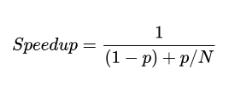

In [2]:
total_time = mandel_time + dump_time
total_time

17.36410427093506

In [3]:
# p = portion of execution time for parallelizable code 
p = mandel_time / total_time
p
# This program is 98% parallelizable!

0.9849396539892198

In [4]:
# Nvidia RTX A2000 - 3328 cores
n_gpu_cores = 3328
speed_up = 1/ ((1-p)+p/n_gpu_cores)
speed_up # Is it worth the effort to program this algorithm to use the GPU?

65.11984700157265

### Profiling the code
- Standard `time` function in Python works fine for our small example program, not feasible for large-scale programs that call on many different functions, some of which may or may not be worth the effort to parallelize, or even optimize on the CPU
- We might miss putting the `time` around some function call
- Donald Knuth: "Premature optimization is the root of all evil."
- "Find candidate portions of the code to offload onto the GPU before we even think about rewriting the code to run on the GPU"
- Profiler: To find out hot spots and bottlenecks in our code by identifying where our program is taking the most time, and allow us to optimize accordingly

### Using cProfile module
- Run the profile: `-m cProfile`
- Organize results by cumulative time spent of each function: `-s cumtime`
- Redirect output into a text file using `>` operator
- Command: `python -m cProfile -s cumtime .\mandelbrot0.py > mandel_profile.txt`
- In `mandel-profile.txt`,
    - Display list of functions that are called in the program, ordered from the cumulatively most time-consuming functions to the least
    -  1st line is the program itself, 2nd line is the simple_mandelbrot function (aligns with measurement via `time` command)
    - Use output from cProfile to infer where the bottlenecks are within a given program.


### Questions
1. There are three for statements in this chapter's Mandelbrot example; however, we can only parallelize over the first two. Why can't we parallelize over all of the for loops here?
2. What is something that Amdahl's Law doesn't account for when we apply it to offloading a serial CPU algorithm to a GPU?
3. Suppose that you gain exclusive access to three new top-secret GPUs that are the same in all respects, except for core counts—the first has 131,072 cores, the second has 262,144 cores, and the third has 524,288 cores. If you parallelize and offload the Mandelbrot example onto these GPUs (which generates a 512 x 512 pixel image), will there be a difference in computation time between the first and second GPU? How about between the second and third GPU?
4. Can you think of any problems with designating certain algorithms or blocks of code as parallelizable in the context of Amdahl's Law?
5. Why should we use profilers instead of just using Python's time function?